In [28]:
import csv
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

### Importation des données et nettoyage 

In [29]:
def importClean_5ind(csv_file_path, desired_returns = 'Average Value Weighted Returns -- Monthly'):
    """
    Cette fonction importe des données à partir d'un fichier CSV spécifié, effectue un nettoyage de données,
    et retourne un DataFrame contenant des données filtrées sans tenir compte de la variable T (nombre d'années).

    Args:
        csv_file_path(str): Chemin vers le fichier CSV avec les données brutes.

    Returns:
        DataFrame: DataFrame contenant les données filtrées.
    """

    # Importation
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        
        # Sauter les 10 premières lignes
        for _ in range(10):
            next(reader)

        # Lire le reste du fichier CSV dans un DataFrame
        df = pd.DataFrame(reader)
        df.columns = df.iloc[1]
        df = df.drop(df.index[1])
        df = df.reset_index(drop=True)

    # Nettoyage
    df = df.rename(columns={df.columns[0]: 'Date'})
    first_row = df[df.iloc[:, 0].str.strip() == desired_returns].index
    df_AEWR_monthly = df.iloc[first_row.values[0] + 2:].reset_index(drop=True)
    last_row = (df_AEWR_monthly['Date'].str.len() != 6).idxmax()
    df_AEWR_monthly = df_AEWR_monthly.iloc[:last_row]
    df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y%m')
    df_AEWR_monthly.iloc[:, 1:] = df_AEWR_monthly.iloc[:, 1:].astype(float)

    # Retourner le DataFrame complet sans filtre temporel
    df_10Ind = df_AEWR_monthly.reset_index(drop=True)
    
    return df_10Ind

In [30]:
df_10ind = importClean_5ind('/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /10_Industry_Portfolios.CSV', desired_returns='Average Value Weighted Returns -- Monthly')
# Set 'Date' column as the index of the DataFrame
df_10ind.set_index('Date', inplace=True)
df_10ind

1,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-08-01,3.97,3.68,2.81,3.47,2.66,2.17,-0.71,4.25,-1.69,4.35
1926-09-01,1.14,4.8,1.15,-3.39,-0.38,2.41,0.21,0.69,2.04,0.29
1926-10-01,-1.24,-8.23,-3.63,-0.78,-4.58,-0.11,-2.29,-0.57,-2.63,-2.84
1926-11-01,5.2,-0.19,4.1,0.01,4.71,1.63,6.43,5.42,3.71,2.11
1926-12-01,0.82,9.89,3.74,2.82,-0.02,1.99,0.62,0.11,-0.17,3.47
...,...,...,...,...,...,...,...,...,...,...
2023-09-01,-4.57,-2.58,-7.08,3.17,-5.98,-3.22,-5.68,-4.71,-5.04,-3.41
2023-10-01,-3.53,-17.88,-2.76,-6.24,-1.78,-0.18,0.47,-4.58,1.12,-2.53
2023-11-01,5.02,15.76,8.68,-1.29,11.96,6.97,7.18,5.87,5.08,10.41


### Avec la bonne date au début


In [31]:
df = pd.read_csv('/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /10_Industry_Portfolios.CSV', header=6)
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.iloc[:1171]
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')
df.set_index('Date', inplace=True)
df =df.apply(pd.to_numeric, errors='coerce')
df_10ind = df

### Importation du taux sans risque historique

In [32]:
def importClean_RF(csv_file_path):
    # Importation des données
    df = pd.read_csv(csv_file_path, skiprows=3)  # Skip the first 3 rows

    # Renommage des colonnes
    df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

    # Suppression des lignes dont la date ne correspond pas au format '%Y%m'
    df = df[df['Date'].str.match(r'^\d{6}$', na=False)]

    # Conversion de 'Date' en datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')

    # Conversion de 'RF' en float
    df['RF'] = df['RF'].astype(float)

    # Retourner uniquement la colonne 'RF'
    return df[['Date', 'RF']]

In [33]:
df_rf = importClean_RF('/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /F-F_Research_Data_Factors.CSV')
df_rf.set_index('Date', inplace=True)
df_rf

,RF
Date,
1926-07-01,0.22
1926-08-01,0.25
1926-09-01,0.23
1926-10-01,0.32
1926-11-01,0.31
...,...
2023-09-01,0.43
2023-10-01,0.47
2023-11-01,0.44


# 7) Calcul du Portefeuille à Variance Minimale (Approche numérique):


In [34]:
def MV_optimize_portfolio(z_bar, Sigma, short_allowed=False):
    """
    Optimise le portefeuille qui minimise la variance du portefeuille avec une contrainte de retour cible (mu_target)
    
    : param z_bar: Série pandas contenant les rendements attendus pour chaque actif du portefeuille.
    : param Sigma: DataFrame pandas représentant la matrice de covariance des rendements des actifs du portefeuille.
    : param short_allowed: Booléen indiquant si les positions de ventes à découvert sont autorisées (True) ou non (False).
    : return: Un DataFrame pandas contenant les poids optimaux pour chaque actif (optimal_w) et la variance minimale du portefeuille (optimal_var).
    """
    assets = z_bar.index
    mu_target = 0.02  # Retour cible de 2%

    # Création d'un nouveau modèle
    m = gp.Model("portfolio")

    # Création de variables pour les poids de chaque actif
    if short_allowed:
        weights = m.addVars(assets, lb=-GRB.INFINITY, name="weights")
    else:
        weights = m.addVars(assets, lb=0, ub=1, name="weights")

    # Variance du portefeuille (objectif à minimiser)
    portfolio_variance = sum(weights[i] * Sigma.loc[i, j] * weights[j] for i in assets for j in assets)

    # Définir l'objectif pour minimiser la variance du portefeuille
    m.setObjective(portfolio_variance, GRB.MINIMIZE)

    # Ajouter des contraintes
    m.addConstr(sum(weights[asset] for asset in assets) == 1, "budget")
    m.addConstr(sum(weights[asset] * z_bar[asset] for asset in assets) >= mu_target, "target_return")

    # Optimiser le modèle
    m.Params.LogToConsole = 0
    m.optimize()

    # Vérifier si l'optimisation a été réussie
    if m.status == GRB.OPTIMAL:
        # Obtenir les poids optimaux et la variance si l'optimisation est réussie
        optimal_w = {asset: weights[asset].X for asset in assets}
        optimal_var = m.objVal

        # Créer un DataFrame pour les résultats
        df_results = pd.DataFrame(optimal_w, index=[0])
        df_results.insert(0, "Return", mu_target)
        df_results.insert(1, "Sigma", optimal_var)
    else:
        print("Optimization was unsuccessful. Unable to retrieve the solution.")
        return None
    
    return df_results

# 1) 2) Calcul du Portefeuille qui maximise le ratio de Sharpe (Approche numérique) avec/sans contrainte de vente à découverte:

In [35]:
def max_sharpe(z_bar, Sigma, Rf, short_allowed=False):
    """
    Optimise les poids de portefeuille pour maximiser le ratio de Sharpe avec et sans contrainte de vente à découvert.

    Parameters:
    - z_bar (pd.Series): Les rendements attendus pour chaque actif.
    - Sigma (pd.DataFrame): La matrice de covariance entre les actifs.
    - Rf (float): Le taux de rendement sans risque.
    - short_allowed (bool): autorise ou non les positions courtes dans le portefeuille.

    Returns:
    - pd.DataFrame | Un DataFrame contenant les poids optimaux de chaque actif dans le portefeuille.
    """
    # Identifier les actifs et leur nombre
    assets = z_bar.index
    number_of_assets = len(assets)
    
    # Initialiser le modèle d'optimisation
    model = gp.Model("max_sharpe")
    
    # Définir les variables de décision: les poids y et la variable auxiliaire kappa
    if short_allowed : 
        y = model.addVars(assets, lb=-100.0, name='weights')
    else: 
        y = model.addVars(assets, lb=0, name='weights')
    kappa = model.addVar(lb=0.0, name='kappa') 
    
    # Construire le vecteur des poids y
    y_vector = [y[i] for i in assets]

    # Calculer la variance du portefeuille (sigma_p) en fonction des poids y et de la matrice de covariance Sigma 
    sigma_p = sum(y_vector[i] * y_vector[j] * Sigma.loc[assets[i], assets[j]]
                    for i in range(number_of_assets) for j in range(number_of_assets))
    
    # Ajouter des contraintes au modèle d'optimisation 
    model.addConstr(sum((z_bar[i] - Rf) * y[i] for i in assets) == 1, "Rendement ajusté") # Contrainte de rendement ajusté normalisé selon k 
    model.addConstr(sum(y[i] for i in assets) == kappa) # Constrainte nécessaire pour que kappa ne soit pas nul 
    
    # Définir l'objectif: Minimiser la variance du portefeuille (Maximiser le ratio de Sharpe)
    model.setObjective(sigma_p, GRB.MINIMIZE)
    
    # Exécuter l'optimisation (sans affichage de console)
    model.Params.LogToConsole = 0
    model.optimize()
    
    # Vérifier si la solution optimale a été trouvée
    if model.status == GRB.OPTIMAL:
        y_opt = model.getAttr('x', y) # Poids optimaux y
        kappa_opt = kappa.X # Valeur optimale de kappa
        
        # Calculer et ajuster les poids du portefeuille original x à partir de y et kappa 
        x_opt = {i: y_opt[i] / (kappa_opt) for i in assets}
        
        # Convertir les poids en DataFrame 
        weights_df = pd.DataFrame([x_opt], columns=assets)
        
        return weights_df
    else:
        print("Optimization failed. Unable to retrieve the solution.")
        return None

# 3) Calcul du Portefeuille où le poids de chaque actif est inversement relié à sa variance:

In [36]:
def Inverse_Variance_Portfolio(Sigma):
    """
    Calculate portfolio weights that are inversely proportional to the asset's variance.
    
    :param Sigma: Pandas DataFrame representing the covariance matrix of asset returns.
    :return: Pandas DataFrame containing the inverse variance weights for each asset.
    """
    # Extract variances from the diagonal of the covariance matrix
    variances = Sigma.values.diagonal()
    inverse_variance_weights = 1 / variances
    normalized_weights = inverse_variance_weights / inverse_variance_weights.sum()
    return pd.DataFrame([normalized_weights], columns=Sigma.index)

# 4) Calcul du portefeuille où le poids de chaque actif est inversement relié à sa volatilité:

In [37]:
def Inverse_Volatility_Portfolio(Sigma):
    """
    Calculate portfolio weights that are inversely proportional to the asset's volatility.
    
    :param Sigma: Pandas DataFrame representing the covariance matrix of asset returns.
    :return: Pandas DataFrame containing the inverse volatility weights for each asset.
    """
    # Calculate the volatility (standard deviation) for each asset
    volatilities = np.sqrt(Sigma.values.diagonal())
    
    # Calculate the inverse volatility for each asset
    inverse_volatility_weights = 1 / volatilities
    
    # Normalize the weights so they sum to 1
    normalized_weights = inverse_volatility_weights / inverse_volatility_weights.sum()
    
    # Create a DataFrame with the normalized weights
    return pd.DataFrame([normalized_weights], columns=Sigma.index)

# 5) Calcul du portefeuille où les actifs ont les mêmes poids:

In [38]:
def Equally_Weighted_Portfolio(assets):
    """
    Calculate equal weights for each asset in a portfolio.
    
    :param Sigma: Pandas DataFrame representing the number of assets in portfolio.
    :return: Pandas DataFrame containing equal weights for each asset in the portfolio.
    """
    n_assets = len(assets)# Number of assets in the portfolio
    equal_weight = 1 / n_assets # Weight for each asset in the portfolio (1/n)
    portfolio_weights = {asset: equal_weight for asset in assets}
    
    return pd.DataFrame([portfolio_weights], columns=assets)

# 6) Calcul du  portefeuille où le poids de chaque est linéairement relié à sa capitalisation boursière

In [39]:
df_number_firm = importClean_5ind('/Users/thomasdeconinck/Downloads/10_Industry_Portfolios.CSV', desired_returns='Number of Firms in Portfolios')
# Set 'Date' column as the index of the DataFrame
df_number_firm.set_index('Date', inplace=True)

df_average_firm_size = importClean_5ind('/Users/thomasdeconinck/Downloads/10_Industry_Portfolios.CSV', desired_returns='Average Firm Size')
# Set 'Date' column as the index of the DataFrame
df_average_firm_size.set_index('Date', inplace=True)

In [40]:
def Optimized_Market_Cap_Weighted_Portfolio(df_average_firm_size, df_number_firm):
    """
    This function calculates weights proportional to the market cap for assets, given average firm size and number of firms.

    :param df_average_firm_size: Pandas DataFrame representing the average firm size for each asset in portfolio over time.
    :param df_number_firm: Pandas DataFrame representing the number of firms for each asset in portfolio over time.
    :return: A pandas DataFrame with market cap weights for each asset over time.
    """
    # Calculate market capitalization for each asset in portfolio over time
    market_caps = df_average_firm_size.multiply(df_number_firm)
    
    # Calculate total market capitalization across all assets for each date
    total_market_cap = market_caps.sum(axis=1)
    
    # Calculate weights for each asset over time
    weights = market_caps.div(total_market_cap, axis='index')
    
    return weights

## Fenêtre "Rolling" de données de 5 ans de 10 portefeuilles d'industrie, qui calcule les portefeuilles suivants pour chaque mois depuis juin 1931 : 
- 1) le portefeuille qui maximise le ratio de Sharpe sans contrainte de vente à découverte
- 2) le portefeuille qui maximise le ratio de Sharpe avec contrainte de vente à découverte
- 3) le portefeuille ou le poids de chaque actif est inversement relié à sa variance
- 4) le portefeuille ou le poids de chaque actif est inversement relié à sa volatilité
- 5) le portefeuille ou les actifs ont les mêmes poids
- 6) le portefeuille ou le poids de chaque est linéairement relié à sa capitalisation boursière
- 7) le portefeuille avec la minimum variance

In [41]:
def rolling_window_optimization(df, window_size, optimization_type='min_variance', short_allowed=False):
    """
    Calculate portfolio weights for each window using a rolling window based on the specified optimization type.

    Args:
    - df (DataFrame): DataFrame containing asset returns for each month with dates as index.
    - window_size (int): Size of the rolling window in months.
    - optimization_type (str): Type of portfolio optimization to perform ('min_variance' for minimum variance portfolio, or other types as needed).
    - short_allowed (bool): Whether short selling is allowed in the optimization.

    Returns:
    - results_df (DataFrame): DataFrame containing portfolio weights for each window with associated dates.
    """   
    results = []
    dates = []

    for start_idx in range(len(df) - window_size + 1):
        window_data = df.iloc[start_idx:start_idx + window_size]
        window_average_firm_size = df_average_firm_size.iloc[start_idx:start_idx + window_size]
        window_number_firm = df_number_firm.iloc[start_idx:start_idx + window_size]
        
        # Calcul des paramètres pour la fonction d'optimisation
        Sigma = window_data.cov()
        z_bar = window_data.mean()
        
        # Appel de la fonction d'optimisation de portefeuille
        if optimization_type == 'min_variance':
            # Call the minimum variance portfolio optimization function
            weights_df = MV_optimize_portfolio(z_bar, Sigma, short_allowed=short_allowed)
            
        elif optimization_type == 'max_sharpe':
            weights_df = max_sharpe(z_bar, Sigma, 0.044, short_allowed)
            
        elif optimization_type == 'inv_variance_weights':
            weights_df = Inverse_Variance_Portfolio(Sigma)
        
        elif optimization_type == 'inv_volatility_weights':
            weights_df = Inverse_Volatility_Portfolio(Sigma)
        
        elif optimization_type == 'equal_weights':
            weights_df = Equally_Weighted_Portfolio(df_10ind.columns)
            
        elif optimization_type == 'market_cap_weights':
            weights_df = Optimized_Market_Cap_Weighted_Portfolio(window_average_firm_size, window_number_firm)
            
        # Vérifie si l'optimisation a retourné des résultats
        if weights_df is not None:  
            # Récupération des poids pour l'optimisateur market_cap_weights 
            if isinstance(weights_df.index, pd.DatetimeIndex):
                weights = weights_df.iloc[-1, :].tolist()
            else:
                weights = weights_df.loc[0, df.columns].tolist() # Récupère les poids optimaux pour la fenêtre actuelle
            results.append(weights) 

            dates.append(window_data.index[-1]) # Utilisation de l'index pour la date de fin de la fenêtre
        # Si l'optimisation a échoué, affiche un message d'erreur
        else:
            print(f"Optimization failed for the window ending on {window_data.index[-1]}")
            
    # Création du DataFrame des résultats
    results_df = pd.DataFrame(results, index=dates, columns=df.columns)
    return results_df
    
def calculate_portfolio_returns(results_df, df):
    """
    Calculate the monthly returns of the portfolios using the optimized weights.
    
    Args:
    - results_df (DataFrame): DataFrame containing the optimized portfolio weights for each window with associated dates as the index.
    - df (DataFrame): DataFrame containing asset returns for each month with dates as the index.
    
    Returns:
    - DataFrame: The input 'results_df' DataFrame with an additional column 'Portfolio Monthly Return' containing the calculated returns for the optimized portfolios.
    """
    portfolio_monthly_returns = []
    
    # Itére sur chaque ligne de 'results_df' pour accéder aux poids optimisés de chaque fenêtre
    for index, row in results_df.iterrows():
        next_month = index + pd.DateOffset(months=1) # Calcule la date correspondant au mois suivant la fin de la fenêtre roulante
        if next_month in df.index:
            next_month_returns = df.loc[next_month]  # Extrait les rendements des actifs pour le mois suivant
            weights = row.values # Extrait les poids optimisés du portefeuille pour la fenêtre actuelle
            portfolio_return = np.dot(weights, next_month_returns) # Calcule le rendement du portefeuille pour le mois suivant
            portfolio_monthly_returns.append(portfolio_return) # Ajouter le rendement calculé du portefeuille à la liste des rendements mensuels
        else:
            portfolio_monthly_returns.append(None)
    
    # Ajouter la liste des rendements mensuels calculés à 'results_df' comme nouvelle colonne
    results_df['Portfolio Monthly Return'] = portfolio_monthly_returns
    return results_df

## Checker cette rolling window pour la facon de récupérer le taux sans risque dans la loop

In [42]:
def rolling_window_optimization(df, window_size, optimization_type='min_variance'):
    """
    Calculate portfolio weights for each window using a rolling window based on the specified optimization type.

    Args:
    - df (DataFrame): DataFrame containing asset returns for each month with dates as index.
    - window_size (int): Size of the rolling window in months.
    - optimization_type (str): Type of portfolio optimization to perform ('min_variance' for minimum variance portfolio, or other types as needed).
    - short_allowed (bool): Whether short selling is allowed in the optimization.

    Returns:
    - results_df (DataFrame): DataFrame containing portfolio weights for each window with associated dates.
    """   
    results = []
    dates = []
    weights_df = None
    
    # Itérer sur chaque fenêtre de la taille spécifiée
    for start_idx in range(len(df) - window_size + 1): 
        window_data = df.iloc[start_idx:start_idx + window_size] # Récupère les rendements pour la fenêtre actuelle
        end = start_idx + window_size 
        window_rf = df_rf.iloc[end - 1, 0] # Récupère le taux sans risque pour le dernier mois de la fenêtre roulante 
        window_average_firm_size = df_average_firm_size.iloc[start_idx:start_idx + window_size] # Récupère les tailles moyennes des entreprises pour la fenêtre actuelle
        window_number_firm = df_number_firm.iloc[start_idx:start_idx + window_size] # Récupère le nombre d'entreprises pour la fenêtre actuelle 
        
        # Calcul de la matrice de covariance et du rendement attendu pour la fenêtre actuelle 
        Sigma = window_data.cov()
        z_bar = window_data.mean()

        # Appel de la fonction d'optimisation de portefeuille
        if optimization_type == 'min_variance_short_allowed':
            # Call the minimum variance portfolio optimization function with short selling allowed
            weights_df = MV_optimize_portfolio(z_bar, Sigma, short_allowed= True)
            
        elif optimization_type == 'max_sharpe_no_short':
            weights_df = max_sharpe(z_bar, Sigma, window_rf, short_allowed= False)

        elif optimization_type == 'max_sharpe_short_allowed':
            weights_df = max_sharpe(z_bar, Sigma, window_rf, short_allowed= True)
            
        elif optimization_type == 'inv_variance_weights':
            weights_df = Inverse_Variance_Portfolio(Sigma)
        
        elif optimization_type == 'inv_volatility_weights':
            weights_df = Inverse_Volatility_Portfolio(Sigma)
        
        elif optimization_type == 'equal_weights':
            weights_df = Equally_Weighted_Portfolio(df_10ind.columns)
            
        elif optimization_type == 'market_cap_weights':
            weights_df = Optimized_Market_Cap_Weighted_Portfolio(window_average_firm_size, window_number_firm)
            
        # Vérifie si l'optimisation a retourné des résultats
        if weights_df is not None:  
            # Récupération des poids pour l'optimisateur market_cap_weights 
            if isinstance(weights_df.index, pd.DatetimeIndex):
                weights = weights_df.iloc[-1, :].tolist()
            else:
                weights = weights_df.loc[0, df.columns].tolist() # Récupère les poids optimaux pour la fenêtre actuelle
            results.append(weights) 

            dates.append(window_data.index[-1]) # Utilisation de l'index pour la date de fin de la fenêtre
        # Si l'optimisation a échoué, affiche un message d'erreur
        else:
            print(f"Optimization failed for the window ending on {window_data.index[-1]}")
            
    # Création du DataFrame des résultats
    results_df = pd.DataFrame(results, index=dates, columns=df.columns)
    return results_df
    
def calculate_portfolio_returns(results_df, df):
    """
    Calculate the monthly returns of the portfolios using the optimized weights.
    
    Args:
    - results_df (DataFrame): DataFrame containing the optimized portfolio weights for each window with associated dates as the index.
    - df (DataFrame): DataFrame containing asset returns for each month with dates as the index.
    
    Returns:
    - DataFrame: The input 'results_df' DataFrame with an additional column 'Portfolio Monthly Return' containing the calculated returns for the optimized portfolios.
    """
    portfolio_monthly_returns = []
    
    # Itére sur chaque ligne de 'results_df' pour accéder aux poids optimisés de chaque fenêtre
    for index, row in results_df.iterrows():
        next_month = index + pd.DateOffset(months=1) # Calcule la date correspondant au mois suivant la fin de la fenêtre roulante
        if next_month in df.index:
            next_month_returns = df.loc[next_month]  # Extrait les rendements des actifs pour le mois suivant
            weights = row.values # Extrait les poids optimisés du portefeuille pour la fenêtre actuelle
            portfolio_return = np.dot(weights, next_month_returns) # Calcule le rendement du portefeuille pour le mois suivant
            portfolio_monthly_returns.append(portfolio_return) # Ajouter le rendement calculé du portefeuille à la liste des rendements mensuels
        else:
            portfolio_monthly_returns.append(None)
    
    # Ajouter la liste des rendements mensuels calculés à 'results_df' comme nouvelle colonne
    results_df['Portfolio Monthly Return'] = portfolio_monthly_returns
    return results_df

In [43]:
results = calculate_portfolio_returns(rolling_window_optimization(df_10ind, 60, optimization_type= 'max_sharpe_short_allowed'), df_10ind)
results

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Monthly Return
1931-06-01,2.726853e+00,-6.154361e-02,-7.820839e-01,-2.005289e-01,1.049048e+00,1.247602e+00,-1.659769e+00,1.429595e+00,5.261050e-01,-3.275278e+00,1.723285e+01
1931-07-01,2.503827e+00,-2.443567e-01,-8.138801e-01,-5.643758e-02,1.007459e+00,1.197995e+00,-1.305753e+00,1.324855e+00,2.520578e-01,-2.865765e+00,1.089939e+01
1931-08-01,2.543033e+00,-2.938050e-01,-8.131208e-01,1.837774e-02,1.097990e+00,1.345280e+00,-1.288821e+00,1.361567e+00,3.031656e-01,-3.273666e+00,-1.944902e+01
1931-09-01,1.163031e+01,-2.649692e+00,-2.940203e+00,-8.430636e-01,9.846193e+00,8.243266e+00,-9.407093e+00,8.887244e+00,1.849138e+00,-2.361610e+01,1.060021e+02
1931-10-01,3.654503e+01,-6.690021e+00,-1.023743e+01,-2.529318e+00,3.431048e+01,2.586166e+01,-3.162497e+01,3.009963e+01,7.745364e+00,-8.248042e+01,1.065684e+03
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,1.686719e+06,2.017649e+06,-1.148900e+05,2.235518e+06,1.130845e+07,-7.541691e+06,-1.001535e+07,4.641511e+05,2.308699e+06,-2.349254e+06,-7.273743e+07
2023-10-01,1.664787e+07,1.469388e+04,-1.157860e+07,-8.743264e+06,-3.896121e+07,3.112923e+07,1.674519e+07,-2.879646e+06,-6.034748e+06,3.660480e+06,-1.436488e+08
2023-11-01,-7.092613e+06,-1.274205e+06,1.503184e+06,7.273047e+06,4.313453e+07,-2.543404e+07,-1.827179e+07,-4.353067e+06,3.940961e+06,5.740015e+05,-4.779259e+06
2023-12-01,-4.965412e+04,-2.028147e+04,3.941209e+03,7.614918e+04,4.828879e+05,-3.519370e+05,-1.785672e+05,-3.007307e+04,-1.493506e+04,8.247066e+04,1.081010e+05


# Plot les cumulatives returns

In [44]:
def plot_cumulative_returns(df, strategies, optimization_function):
    """
    Cette fonction trace les rendements cumulatifs pour les 7 stratégies.

    :param df: DataFrame contenant les données de rendement.
    :param strategies: Liste des stratégies à utiliser.
    :param optimization_function: Fonction d'optimisation de portefeuille à utiliser.
    """
    def calculer_retours_cumulatifs(retours_mensuels):
        """
        Cette fonction calcule les retours cumulatifs à partir des séries de returns mensuels pour les 7 stratégies.

        :param retours_mensuels: Pandas Series contenant les retours mensuels du portefeuille en décimal.
        :return: Pandas Series contenant les retours cumulatifs du portefeuille.
        """
        # Convertir les pourcentages en décimales et ajouter 1
        retours_ajustes = retours_mensuels / 100 + 1

        # Calculer les retours cumulatifs
        retours_cumulatifs = retours_ajustes.cumprod()

        return retours_cumulatifs

    # Initialiser le dictionnaire pour stocker les résultats
    results_dict = {}

    # Boucle sur chaque stratégie
    for strategy in strategies:
        # Appeler la fonction d'optimisation pour chaque stratégie
        results_df = calculate_portfolio_returns(optimization_function(df, 60, optimization_type=strategy), df)
        
        # Stocker les résultats dans le dictionnaire
        results_dict[strategy] = results_df

    plt.figure(figsize=(15,10))

    # Boucle sur chaque stratégie
    for strategy in strategies:
        # Récupérer les rendements de la stratégie
        results_with_returns = results_dict[strategy]
        
        # Supprimer ou remplir les valeurs NaN
        results_with_returns['Portfolio Monthly Return'].dropna(inplace=True)
        
        # Calculer les rendements cumulatifs
        results_with_returns['Cumulative Return'] = calculer_retours_cumulatifs(results_with_returns['Portfolio Monthly Return'])

        # Tracer les rendements cumulatifs
        plt.plot(results_with_returns.index, results_with_returns['Cumulative Return'], label=strategy)

    plt.title('Cumulative Returns of Portfolio Strategies (out-of-sample)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns (%)')  
    plt.legend()
    plt.grid(True)
    plt.show()

Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1932-05-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1932-06-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1933-03-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1933-04-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1941-12-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1942-01-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1942-03-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1974-04-01 00:00:00
Optimization failed. Unable to retrieve the solu

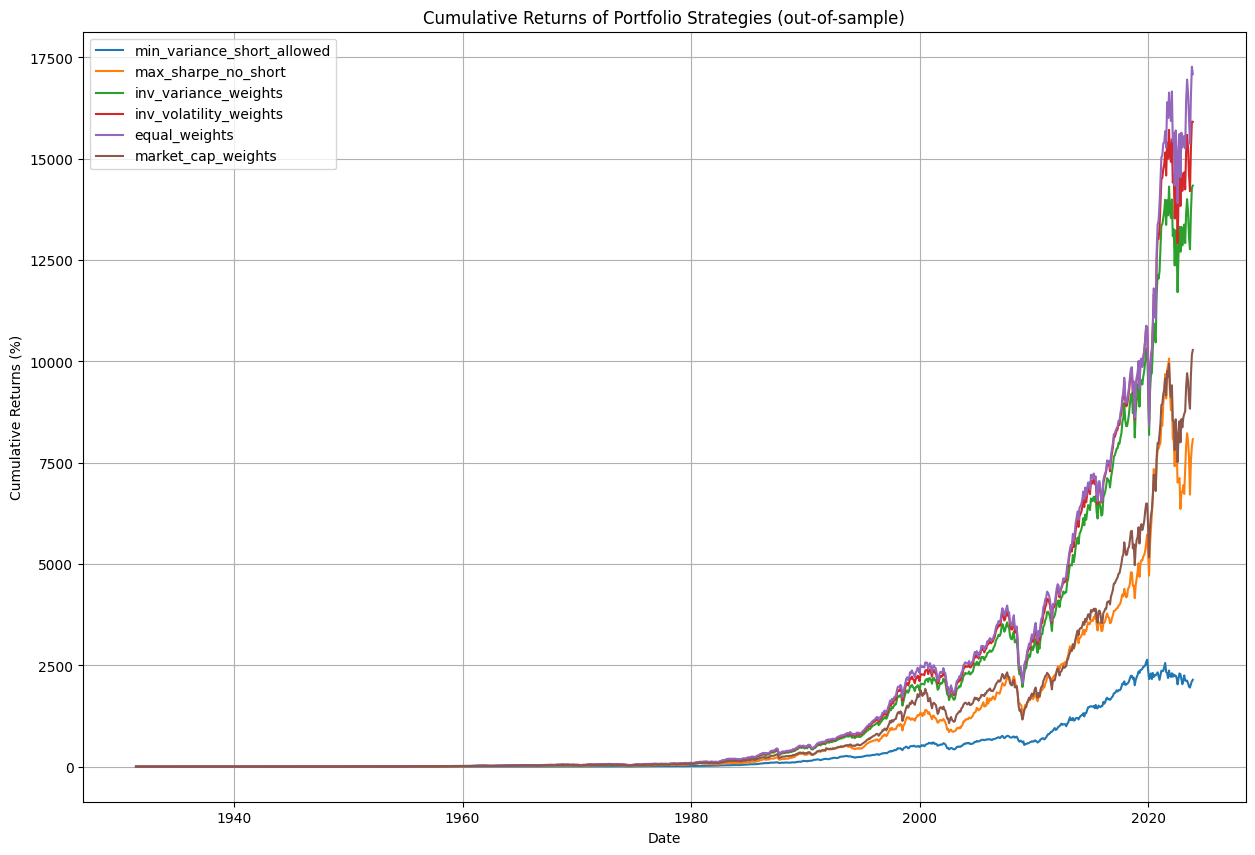

In [45]:
strategies = ['min_variance_short_allowed', 'max_sharpe_no_short', 'inv_variance_weights', 'inv_volatility_weights', 'equal_weights', 'market_cap_weights']
plot_cumulative_returns(df_10ind, strategies, rolling_window_optimization)

# Calcul des Sharpe ratios pour chacund es portefeuilles 

In [46]:
def calculate_sharpe_ratios(df, df_rf, strategies, window):
    # Dictionnaire pour stocker les ratios de Sharpe pour chaque stratégie
    sharpe_ratios = {}

    # Calculer les rendements du portefeuille pour chaque stratégie
    for strategy in strategies:
        results = calculate_portfolio_returns(rolling_window_optimization(df, window, optimization_type=strategy), df)
        
        # Extraire les rendements du portefeuille
        portfolio_returns = results['Portfolio Monthly Return']
        portfolio_returns.dropna(inplace=True)
        
        # Calculer le ratio de Sharpe
        portfolio_variance = portfolio_returns.var()
        Sigma = np.sqrt(portfolio_variance)
        sharpe_ratio = (portfolio_returns.mean() - df_rf.mean().values) / Sigma
        
        # Stocker le ratio de Sharpe dans le dictionnaire
        sharpe_ratios[strategy] = sharpe_ratio

    # Convertir le dictionnaire en DataFrame
    sharpe_ratios_df = pd.DataFrame(list(sharpe_ratios.items()), columns=['Strategy', 'Sharpe Ratio'])

    return sharpe_ratios_df

In [47]:
strategies = ['min_variance_short_allowed', 'max_sharpe_no_short', 'max_sharpe_short_allowed', 'inv_variance_weights', 'inv_volatility_weights', 'equal_weights', 'market_cap_weights']
sharpe_ratios_df = calculate_sharpe_ratios(df_10ind, df_rf, strategies, 60)
sharpe_ratios_df

Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1932-05-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1932-06-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1933-03-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1933-04-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1941-12-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1942-01-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1942-03-01 00:00:00
Optimization failed. Unable to retrieve the solution.
Optimization failed for the window ending on 1974-04-01 00:00:00
Optimization failed. Unable to retrieve the solu

,Strategy,Sharpe Ratio
0,min_variance_short_allowed,[0.13608089683199273]
1,max_sharpe_no_short,[0.13531643265400947]
2,max_sharpe_short_allowed,[-0.0037633377508380548]
3,inv_variance_weights,[0.15136183340808995]
4,inv_volatility_weights,[0.14883366713555046]
5,equal_weights,[0.1456415715746889]
6,market_cap_weights,[0.13474503325359327]


## Test "manuel" pour vérifier la rolling window

In [48]:
def select_data_range(df, start_date, end_date):
    """
    Sélectionne une plage de données de 'start_date' à 'end_date' inclusivement.
    
    Args:
    - df (DataFrame): DataFrame contenant les données avec l'index en tant que dates.
    - start_date (str): Date de début au format 'YYYY-MM-DD'.
    - end_date (str): Date de fin au format 'YYYY-MM-DD'.
    
    Returns:
    - DataFrame: Les données filtrées.
    """
    # Filtrage du DataFrame basé sur la plage de dates
    filtered_df = df.loc[start_date:end_date]
    return filtered_df

# Exemple d'utilisation
start_date = '1926-08-01'
end_date = '1931-07-01'

# Sélection des données pour la plage spécifiée
window_df = select_data_range(df_10ind, start_date, end_date)

# Calcul des rendements moyens et de la matrice de covariance pour la plage de données
mean_returns = window_df.mean()
cov_matrix = window_df.cov()

# Définir le rendement cible pour le portefeuille
mu_target = 0.02  # 2%

# Appel à MV_optimize_portfolio avec les paramètres calculés
# Assurez-vous que la fonction MV_optimize_portfolio est définie pour accepter les arguments corrects
optimized_portfolio = max_sharpe(mean_returns, cov_matrix, mu_target, short_allowed=False)

# Affichage des poids du portefeuille
optimized_portfolio

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,9.796607e-10,3.225360e-10,2.729533e-10,1.799679e-10,8.807969e-10,0.443935,2.706590e-10,0.477046,0.079019,2.287266e-10


In [49]:
# Exemple d'utilisation
start_date = '1926-07-01'
end_date = '1931-06-01'

# Sélection des données pour la plage spécifiée
window_df = select_data_range(df_10ind, start_date, end_date)

# Calcul des rendements moyens et de la matrice de covariance pour la plage de données
mean_returns = window_df.mean()
cov_matrix = window_df.cov()

# Boucle sur les taux sans risque
for date, rf in df_rf.loc[start_date:end_date].iterrows():
    # Appel à max_sharpe avec les paramètres calculés
    optimized_portfolio = max_sharpe(mean_returns, cov_matrix, rf[0], short_allowed=True)
    
print(f"Portefeuille optimisé pour la date {date} avec un taux sans risque de {rf[0]} :\n{optimized_portfolio.to_string()}")

Portefeuille optimisé pour la date 1931-06-01 00:00:00 avec un taux sans risque de 0.08 :
      NoDur     Durbl     Manuf     Enrgy     HiTec     Telcm     Shops     Hlth      Utils     Other
0  2.726853 -0.061544 -0.782084 -0.200529  1.049048  1.247602 -1.659769  1.429595  0.526105 -3.275278


/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_59174/438836836.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  optimized_portfolio = max_sharpe(mean_returns, cov_matrix, rf[0], short_allowed=True)
/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_59174/438836836.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Portefeuille optimisé pour la date {date} avec un taux sans risque de {rf[0]} :\n{optimized_portfolio.to_string()}")
